In [1]:
## Logistic Regression on Amazon FFR 


# Data source - URL https://www.kaggle.com/snap/amazon-fine-food-reviews

## Data Contains reviews of fine food from Amazon. 
## It includes information about product, user, ratings, text review. 



In [2]:
## Objective: 
    # 1. Apply SVM (RBF) on Amazon FFR using BOW, Word2Vec, TFIDF, AvgWord2Vec
    # 2. Metrics: Accuracy, precision, recall, f1-score etc. Confusion matrix
    # 3. Use GridSearchCV and RandomSearchCV to find out best Params like "C", "sigma(in RBF)"

## Predict the Polarity of a given review

In [3]:
## Columns 
    # 1.Id
    # 2.ProductId - unique identifier for the product
    # 3.UserId - unqiue identifier for the user
    # 4.ProfileName
    # 5.HelpfulnessNumerator - number of users who found the review helpful
    # 6.HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
    # 7.Score - rating between 1 and 5
    # 8.Time - timestamp for the review
    # 9.Summary - brief summary of the review
    # 10.Text - text of the review

In [4]:
#######################################################################

# Lets start with imports 


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3 as sql
import seaborn as sns
from time import time
import random
import gensim
import warnings


from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score

warnings.filterwarnings("ignore")

%matplotlib inline 

C:\ProgramData\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [5]:
## Load from SQL file (sqlite)

con = sql.connect('final.sqlite') ## This file obtained after text preprocessing in previous chapter 

df = pd.read_sql_query(''' SELECT * from Reviews''', con)

df.head()

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText,CleanedText_NoStem
0,0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,Positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,b'bought sever vital can dog food product foun...,b''
1,1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,Negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,b'product arriv label jumbo salt peanutsth pea...,b''
2,2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,Positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,b'confect around centuri light pillowi citrus ...,b''
3,3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,Negative,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,b'look secret ingredi robitussin believ found ...,b''
4,4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,Positive,1350777600,Great taffy,Great taffy at a great price. There was a wid...,b'great taffi great price wide assort yummi ta...,b''


In [6]:
print (df.shape)
print (df['Score'].size)
df.describe()

(364171, 13)
364171


,index,Id,HelpfulnessNumerator,HelpfulnessDenominator,Time
count,364171.000000,364171.000000,364171.000000,364171.000000,3.641710e+05
mean,241825.377603,261814.561014,1.739021,2.186841,1.296135e+09
std,154519.869452,166958.768333,6.723921,7.348482,4.864772e+07
min,0.000000,1.000000,0.000000,0.000000,9.393408e+08
25%,104427.500000,113379.500000,0.000000,0.000000,1.270858e+09
50%,230033.000000,249445.000000,0.000000,1.000000,1.311379e+09
75%,376763.500000,407408.500000,2.000000,2.000000,1.332893e+09
max,525813.000000,568454.000000,866.000000,878.000000,1.351210e+09


In [7]:
### Convert Score back to 1 or 0 

def polarity(x):
    if x == 'Positive':
        return 1
    return 0

df['Score'] = df['Score'].map(polarity)

df.head()

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText,CleanedText_NoStem
0,0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,b'bought sever vital can dog food product foun...,b''
1,1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,b'product arriv label jumbo salt peanutsth pea...,b''
2,2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,b'confect around centuri light pillowi citrus ...,b''
3,3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,0,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,b'look secret ingredi robitussin believ found ...,b''
4,4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,1,1350777600,Great taffy,Great taffy at a great price. There was a wid...,b'great taffi great price wide assort yummi ta...,b''


In [9]:
## Select samples 

n_samples = 15000
df_sample = df.sample(n_samples)

## Sorting based on Time 
df_sample.sort_values('Time', inplace=True)
df_sample.head()

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText,CleanedText_NoStem
104684,121041,131217,B00004RAMX,A5NQLNC6QPGSI,Kim Nason,7,8,1,965001600,End your Gopher Problems,I have just recently purchased the Woodstream ...,b'recent purchas woodstream corp gopher trap w...,b''
169366,212557,230375,B00004RYGX,A3K3YJWV0N54ZO,Joey,2,3,1,1001289600,"Beetlejuice is a greatmovie, but they cheated ...",Just to warn you. when in trying to trick you ...,b'warn tri trick widescreen format compani mad...,b''
169331,212522,230337,B00004RYGX,A1CAA94EOP0J2S,Travis J Smith,4,4,1,1036022400,Great Comedy,Beetlejuice is the story of ghosts (Alec Baldw...,b'beetlejuic stori ghost alec baldwin geena da...,b''
169321,212512,230327,B00004RYGX,A3M5O6UHXO9IBU,Gary,2,34,0,1052265600,Certificate: Puerile,Embarrassing comedy that comes over like a chi...,b'embarrass comedi come like child attent defi...,b''
281003,390522,422248,B0000D9N9A,A3LFT71N1YOQXN,Bell Mays,14,16,1,1068422400,Hot Sizzling bubbly Raclette! ! Bubbly Bubbly...,Put in under a Reclette grill or just put it i...,b'put reclett grill put oven minut serv boil b...,b''


In [10]:
## Saving to File 

import pickle

def savetofile(obj,filename):
    pickle.dump(obj,open(filename+".p","wb"))
def openfromfile(filename):
    temp = pickle.load(open(filename+".p","rb"))
    return temp

savetofile(df_sample, "SVM_data_15k")
df_sample = openfromfile("SVM_data_15k")

In [11]:
df.describe()

,index,Id,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time
count,364171.000000,364171.000000,364171.000000,364171.000000,364171.000000,3.641710e+05
mean,241825.377603,261814.561014,1.739021,2.186841,0.843178,1.296135e+09
std,154519.869452,166958.768333,6.723921,7.348482,0.363633,4.864772e+07
min,0.000000,1.000000,0.000000,0.000000,0.000000,9.393408e+08
25%,104427.500000,113379.500000,0.000000,0.000000,1.000000,1.270858e+09
50%,230033.000000,249445.000000,0.000000,1.000000,1.000000,1.311379e+09
75%,376763.500000,407408.500000,2.000000,2.000000,1.000000,1.332893e+09
max,525813.000000,568454.000000,866.000000,878.000000,1.000000,1.351210e+09


In [13]:
############################################################### 

## BOW - Bag of Words .. Convert Text column to Vectors based on BOW technique

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn import preprocessing


X_train, X_test, y_train, y_test = train_test_split(df_sample['CleanedText'].values,
                                                    df_sample['Score'].values,
                                                    test_size=0.3,
                                                    shuffle=False)

uni_gram = CountVectorizer() ## By Default uni_gram is created

X_train = uni_gram.fit_transform(X_train)
X_train_scaled = preprocessing.StandardScaler(X_train)

X_train = preprocessing.normalize(X_train)
## Normalization is the process of scaling individual samples to have unit norm.
# Helpful when used with dot-product or along with Kernel (Similarity)

print (X_train.shape)

X_test = uni_gram.transform(X_test)

X_test_scaled = preprocessing.StandardScaler(X_test)

## Normalize 
X_test =  preprocessing.normalize(X_test)

print (X_test.shape)

(10500, 19668)
(4500, 19668)


In [14]:
## Scaler - StandardScaler, MinMaxScaler - (Scaling data to certain range)
## Imputer - Imputing Missing vlaues with mean, median or mode etc
## LabelEncder - Encode Labels/Categorical values
## OneHot Encoder - create features for categorical values
## Binning - Bin/split certain Numerical continuous data  into ranges 

## Normalize - Normal Form of vectos ||x|| -- (Unit Vector). Used in dot-product, kernels, similarity function

## CountVectorizer - Convert into BOW 

In [19]:
### TimeseriesSplit Cross Validation 
## sklearn.model_selection.TimeseriesSplit splits data into Timeseries intervals
  ## For example a = [1, 2, 3, 4, 5], TimeseriesSplit(n_splits=5) splits a = {[1], [1, 2], [1,2 3], [1, 2, 3, 4], [1,2,3,4,5]}

from sklearn.model_selection import TimeSeriesSplit

tscv = TimeSeriesSplit(n_splits=5)

print (X_train.shape)
for train, cv in tscv.split(X_train):
    print ("Train Shape = : ", X_train[train].shape, " :: CV Shape = ", X_train[cv].shape)
    print ("Train = ", train.shape, " :: CV = ", cv.shape)

(10500, 19668)
Train Shape = :  (1750, 19668)  :: CV Shape =  (1750, 19668)
Train =  (1750,)  :: CV =  (1750,)
Train Shape = :  (3500, 19668)  :: CV Shape =  (1750, 19668)
Train =  (3500,)  :: CV =  (1750,)
Train Shape = :  (5250, 19668)  :: CV Shape =  (1750, 19668)
Train =  (5250,)  :: CV =  (1750,)
Train Shape = :  (7000, 19668)  :: CV Shape =  (1750, 19668)
Train =  (7000,)  :: CV =  (1750,)
Train Shape = :  (8750, 19668)  :: CV Shape =  (1750, 19668)
Train =  (8750,)  :: CV =  (1750,)


In [20]:
%%time

#################### Lets train our with SVC (rbf) and find out best hyper param C, gamma

from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

model = SVC() ## By default kernel = RBF, Other kernels are - Polynomial, Linear, sigmoid, Callable's

param_grid = {'gamma': [100, 10, 1, 0.5, 0.1, 0.01], 
             "C": [100, 10, 1, 0.1, 0.001]}

gsv = GridSearchCV(model, param_grid, cv=tscv, verbose=1, n_jobs=-1)

gsv.fit(X_train, y_train)

print ("Best HyperParameter : ", gsv.best_params_)


Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed: 16.4min finished


Best HyperParameter :  {'C': 100, 'gamma': 0.01}


AttributeError: 'GridSearchCV' object has no attribute 'best_score'

Best Score/Accuracy :  89.53142857142858
Accuracy  89.44444444444444
Precision  0.9093925472179684
Recall  0.9674178658702145
F1-Score  0.9375082226022892


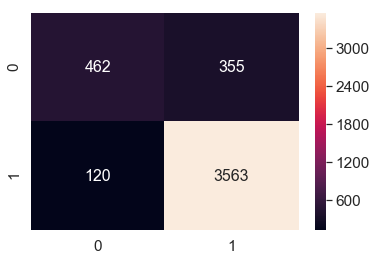

In [22]:
### Accuracy SVC (kernel=rbf), Uni_gram, GridSearchCV

print ("Best Score/Accuracy : ", gsv.best_score_ * 100)

from sklearn.svm import SVC

model = SVC(C=gsv.best_params_['C'], gamma=gsv.best_params_['gamma']) 
## C = Hyperparamter in Loss ::: inverse to lambda in Logistic loss 
## gamma = hyperpamater in RBF (equal to K in knn), gamma says how many nearest points to consider in similarity function

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("Accuracy ", (accuracy_score(y_test, y_pred)*100))
print("Precision ", (precision_score(y_test, y_pred)))
print("Recall ", (recall_score(y_test, y_pred)))
print("F1-Score ", (f1_score(y_test, y_pred)))

df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size

sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

In [23]:
%%time
############# Using SVC, RBF Kernel, Uni_gram, RandomSearchCV

from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVC

model = SVC(kernel='rbf')

param_grid = {'gamma': [100, 10, 1, 0.5, 0.1, 0.01], 
             "C": [100, 10, 1, 0.1, 0.001]}

tscv = TimeSeriesSplit(n_splits=5)
gsv = RandomizedSearchCV(model, param_grid, cv=tscv, verbose=1, n_jobs=-1, n_iter=15)

gsv.fit(X_train, y_train)

print ("Best HyperParameter : ", gsv.best_params_)
print ("Best Score/Accuracy  : ", gsv.best_score_ * 100 )


Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed: 10.7min finished


Best HyperParameter :  {'gamma': 0.1, 'C': 10}
Best Score/Accuracy  :  89.45142857142856
Wall time: 11min 7s


Accuracy  89.64444444444445
Precision  0.9100178434871272
Recall  0.9693184903611186
F1-Score  0.9387325795424665
Wall time: 33.9 s


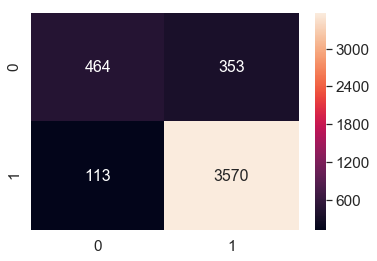

In [24]:
%%time
### Accuracy SVC (kernel=rbf), Uni_gram, RandomSearchCV

from sklearn.svm import SVC

model = SVC(C=gsv.best_params_['C'], gamma=gsv.best_params_['gamma']) 
## C = Hyperparamter in Loss ::: inverse to lambda in Logistic loss 
## gamma = hyperpamater in RBF (equal to K in knn), gamma says how many nearest points to consider in similarity function

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("Accuracy ", (accuracy_score(y_test, y_pred)*100))
print("Precision ", (precision_score(y_test, y_pred)))
print("Recall ", (recall_score(y_test, y_pred)))
print("F1-Score ", (f1_score(y_test, y_pred)))

df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size

sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

In [27]:
%%time
######################### Bi-Gram, SVC, GridSearchCV

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn import preprocessing 

X_train, X_test, y_train, y_test, = train_test_split(df_sample['CleanedText'].values,
                                                    df_sample['Score'].values,
                                                    test_size=0.3,
                                                    shuffle=False, 
                                                    random_state=0)

bi_gram = CountVectorizer(ngram_range=(2,2))  ## considering only bigrams .. not unigrams 

X_train = bi_gram.fit_transform(X_train)

## normalize Data 
X_train = preprocessing.normalize(X_train)

X_test = bi_gram.transform(X_test)

print("Train Data Size: ",X_train.shape)

X_test = preprocessing.normalize(X_test)

print("Test Data Size: ",X_train.shape)

Train Data Size:  (10500, 232711)
Test Data Size:  (10500, 232711)
Wall time: 1.91 s


In [28]:
%%time

#################### SVC, Bi-gram, BOW, GridSearchCV, RBF kernel, "C", "gamma"


from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

model = SVC() ## By default kernel = RBF, Other kernels are - Polynomial, Linear, sigmoid, Callable's

param_grid = {'gamma': [100, 10, 1, 0.5, 0.1, 0.01], 
             "C": [100, 10, 1, 0.1, 0.001]}

gsv = GridSearchCV(model, param_grid, cv=tscv, verbose=1, n_jobs=-1)

gsv.fit(X_train, y_train)

print ("Best HyperParameter : ", gsv.best_params_)


Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  6.5min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed: 22.4min finished


Best HyperParameter :  {'C': 100, 'gamma': 0.01}


AttributeError: 'GridSearchCV' object has no attribute 'best_score'

Best Score/Accoracy :  86.4
Accuracy  87.3111111111111
Precision  0.8780369290573372
Recall  0.9812652728753734
F1-Score  0.9267854853186306
Wall time: 1min 50s


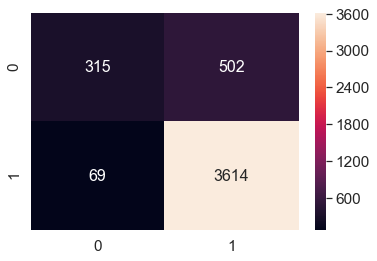

In [29]:
%%time
### Accuracy SVC (kernel=rbf), bi-gram, GridSearchCV 

print ("Best Score/Accoracy : ", gsv.best_score_ * 100)

from sklearn.svm import SVC

model = SVC(C=gsv.best_params_['C'], gamma=gsv.best_params_['gamma']) 
## C = Hyperparamter in Loss ::: inverse to lambda in Logistic loss 
## gamma = hyperpamater in RBF (equal to K in knn), gamma says how many nearest points to consider in similarity function

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("Accuracy ", (accuracy_score(y_test, y_pred)*100))
print("Precision ", (precision_score(y_test, y_pred)))
print("Recall ", (recall_score(y_test, y_pred)))
print("F1-Score ", (f1_score(y_test, y_pred)))

df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size

sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

In [30]:
%%time

#################### SVC, Bi-gram, BOW, RandomSearchCV, RBF kernel, "C", "gamma"


from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVC

model = SVC() ## By default kernel = RBF, Other kernels are - Polynomial, Linear, sigmoid, Callable's

param_grid = {'gamma': [100, 10, 1, 0.5, 0.1, 0.01], 
             "C": [100, 10, 1, 0.1, 0.001]}

gsv = RandomizedSearchCV(model, param_grid, cv=tscv, verbose=1, n_jobs=-1)

gsv.fit(X_train, y_train)

print ("Best HyperParameter : ", gsv.best_params_)


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  9.0min finished


Best HyperParameter :  {'gamma': 0.5, 'C': 10}


AttributeError: 'RandomizedSearchCV' object has no attribute 'best_score'

Best Score/Accoracy :  85.78285714285714
Accuracy  85.97777777777777
Precision  0.8595664467483506
Recall  0.9904968775454792
F1-Score  0.9203986375678063
Wall time: 2min 3s


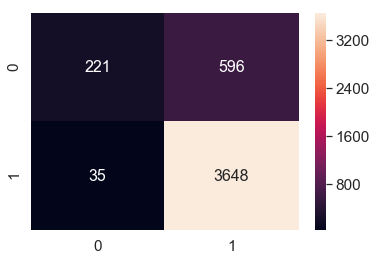

In [31]:
%%time
### Accuracy SVC (kernel=rbf), bi-gram, GridSearchCV 

print ("Best Score/Accoracy : ", gsv.best_score_ * 100)

from sklearn.svm import SVC

model = SVC(C=gsv.best_params_['C'], gamma=gsv.best_params_['gamma']) 
## C = Hyperparamter in Loss ::: inverse to lambda in Logistic loss 
## gamma = hyperpamater in RBF (equal to K in knn), gamma says how many nearest points to consider in similarity function

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("Accuracy ", (accuracy_score(y_test, y_pred)*100))
print("Precision ", (precision_score(y_test, y_pred)))
print("Recall ", (recall_score(y_test, y_pred)))
print("F1-Score ", (f1_score(y_test, y_pred)))

df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size

sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

In [32]:
%%time
##################################################################################3

## TfIdf vectorizer , uni_gram, TfIDf



from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

#Breaking into Train and test
X_train, X_test, y_train, y_test = train_test_split(df_sample['CleanedText'].values,
                                                    df_sample['Score'].values,
                                                    test_size=0.3,
                                                    shuffle=False)

tfidf = TfidfVectorizer() #Using bi-grams
X_train = tfidf.fit_transform(X_train)

#Normalize Data

X_train = preprocessing.normalize(X_train)
print("Train Data Size: ",X_train.shape)

X_test = tfidf.transform(X_test)
#Normalize Data

X_test = preprocessing.normalize(X_test)
print("Test Data Size: ",X_test.shape)

Train Data Size:  (10500, 19668)
Test Data Size:  (4500, 19668)
Wall time: 698 ms


In [33]:
%%time

#################### SVC, uni-gram, TfIdf, GridSearchCV, RBF kernel, "C", "gamma"


from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

model = SVC() ## By default kernel = RBF, Other kernels are - Polynomial, Linear, sigmoid, Callable's

param_grid = {'gamma': [100, 10, 1, 0.5, 0.1, 0.01], 
             "C": [100, 10, 1, 0.1, 0.001]}

gsv = GridSearchCV(model, param_grid, cv=tscv, verbose=1, n_jobs=-1)

gsv.fit(X_train, y_train)

print ("Best HyperParameter : ", gsv.best_params_)
print ("Best Score/Accuracy : ", gsv.best_score_ * 100)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed: 15.4min finished


Best HyperParameter :  {'C': 10, 'gamma': 0.1}
Best Score/Accuracy :  89.06285714285714
Wall time: 15min 43s


Accuracy  89.17777777777778
Precision  0.9091141833077317
Recall  0.9641596524572359
F1-Score  0.9358281723547239
Wall time: 22.6 s


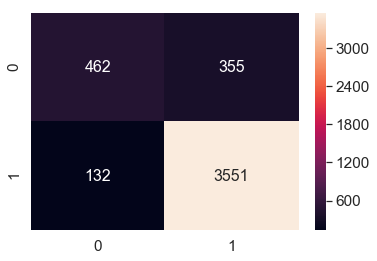

In [35]:
%%time
### Accuracy SVC (kernel=rbf), uni-gram, TfIdf,  GridSearchCV 

from sklearn.svm import SVC

model = SVC(C=gsv.best_params_['C'], gamma=gsv.best_params_['gamma']) 
## C = Hyperparamter in Loss ::: inverse to lambda in Logistic loss 
## gamma = hyperpamater in RBF (equal to K in knn), gamma says how many nearest points to consider in similarity function

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("Accuracy ", (accuracy_score(y_test, y_pred)*100))
print("Precision ", (precision_score(y_test, y_pred)))
print("Recall ", (recall_score(y_test, y_pred)))
print("F1-Score ", (f1_score(y_test, y_pred)))

df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size

sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

In [36]:
### SKipping bi-gram, and Randomized Search for TfIdf .. as it is taking huge time 



In [38]:
%%time

############## Using SGDClassifier with Hinge Loss. 

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import TimeSeriesSplit

clf = SGDClassifier()
## by defualt loss = hinge, others = log, huber, modified_huber, squared_hinge, perceptron, regression_loss, 
## Log loss gives LogisticRegression, 
#params we need to try on classifier
param_dist = {'penalty':['l1','l2','elasticnet'],
             'alpha':[500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001,0.00005,0.00001]} 

tscv = TimeSeriesSplit(n_splits=10) #For time based splitting
gsv = GridSearchCV(clf,param_dist,cv=tscv,verbose=1)

gsv.fit(X_train,y_train)

print("Best HyperParameter: ",gsv.best_params_)
print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))

Fitting 10 folds for each of 48 candidates, totalling 480 fits
Best HyperParameter:  {'alpha': 0.0001, 'penalty': 'l2'}
Best Accuracy: 89.18%
Wall time: 7.75 s


[Parallel(n_jobs=1)]: Done 480 out of 480 | elapsed:    7.6s finished


Accuracy  88.95555555555555
Precision  0.8984492246123061
Recall  0.975291881618246
F1-Score  0.9352948834787136
Wall time: 74.8 ms


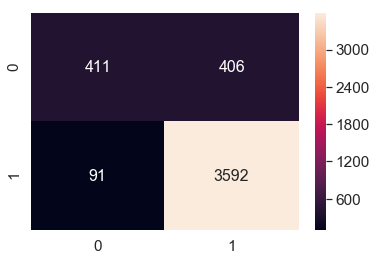

In [39]:
%%time
### Accuracy SVC (kernel=rbf), uni-gram, TfIdf,  GridSearchCV 

from sklearn.linear_model import SGDClassifier

model = SGDClassifier(alpha=gsv.best_params_['alpha'], penalty=gsv.best_params_['penalty']) 

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("Accuracy ", (accuracy_score(y_test, y_pred)*100))
print("Precision ", (precision_score(y_test, y_pred)))
print("Recall ", (recall_score(y_test, y_pred)))
print("F1-Score ", (f1_score(y_test, y_pred)))

df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size

sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')